# Image Recognition - Attractiveness Detection

---

## Dataset

For this project we will use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), which is available on Kaggle.

Description of the CelebA dataset from kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset): 

### Context

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).

### Content

#### Overall

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations

#### Data Files

- <b>img_align_celeba.zip</b>: All the face images, cropped and aligned
- <b>list_eval_partition.csv</b>: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- <b>list_bbox_celeba.csv</b>: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- <b>list_landmarks_align_celeba.csv</b>: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- <b>list_attr_celeba.csv</b>: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

---


### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)

1.11.0-rc1


## Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

In [3]:
# set variables 
main_folder = '../input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = images_folder + '000001.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 32
NUM_EPOCHS = 20

### Load the attributes of every picture
File: list_attr_celeba.csv

---

### Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
print(df_attr.shape)
df_attr.head()

(202599, 40)


,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [5]:
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 40 columns):
5_o_Clock_Shadow       202599 non-null int64
Arched_Eyebrows        202599 non-null int64
Attractive             202599 non-null int64
Bags_Under_Eyes        202599 non-null int64
Bald                   202599 non-null int64
Bangs                  202599 non-null int64
Big_Lips               202599 non-null int64
Big_Nose               202599 non-null int64
Black_Hair             202599 non-null int64
Blond_Hair             202599 non-null int64
Blurry                 202599 non-null int64
Brown_Hair             202599 non-null int64
Bushy_Eyebrows         202599 non-null int64
Chubby                 202599 non-null int64
Double_Chin            202599 non-null int64
Eyeglasses             202599 non-null int64
Goatee                 202599 non-null int64
Gray_Hair              202599 non-null int64
Heavy_Makeup           202599 non-null int64
High_Cheekbones        202

### List of the available attribute in the CelebA dataset

40 Attributes

In [6]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000001.jpg, dtype: int64

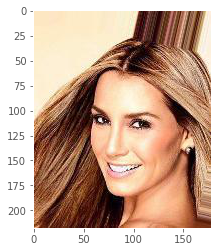

In [7]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

### Distribution of the Attribute

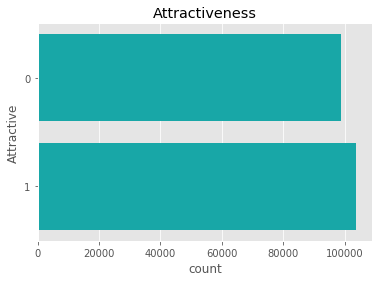

In [8]:
plt.title('Attractiveness')
sns.countplot(y='Attractive', data=df_attr, color="c")
plt.savefig('Attractive_distribution.png')
plt.show()

---
## Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

In [9]:
bbox = pd.read_csv(main_folder + 'list_bbox_celeba.csv')
bbox.set_index('image_id', inplace=True)
print(bbox.shape)
bbox.head()

(202599, 4)


,x_1,y_1,width,height
image_id,,,,
000001.jpg,95,71,226,313
000002.jpg,72,94,221,306
000003.jpg,216,59,91,126
000004.jpg,622,257,564,781
000005.jpg,236,109,120,166


In [10]:
bbox.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 4 columns):
x_1       202599 non-null int64
y_1       202599 non-null int64
width     202599 non-null int64
height    202599 non-null int64
dtypes: int64(4)
memory usage: 7.7+ MB


In [11]:
def graph(feature1, feature2, data):
    plt.figure(figsize=(10, 6))
    plt.hist([data[feature1], data[feature2]], bins=30, color=['blue', 'orange'], alpha=0.7, label=[feature1, feature2])
    plt.title(f'Distribution of {feature1} and {feature2}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'{feature1}_and_{feature2}.png')
    plt.show()

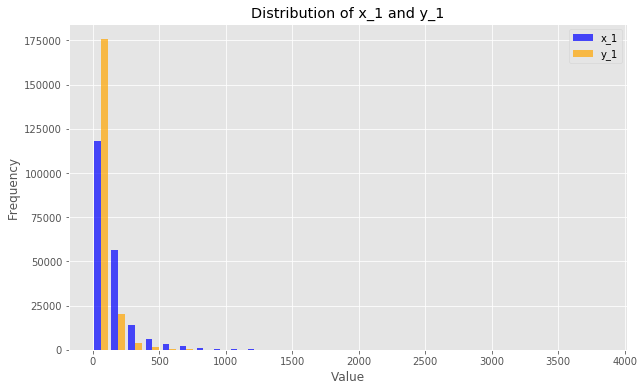

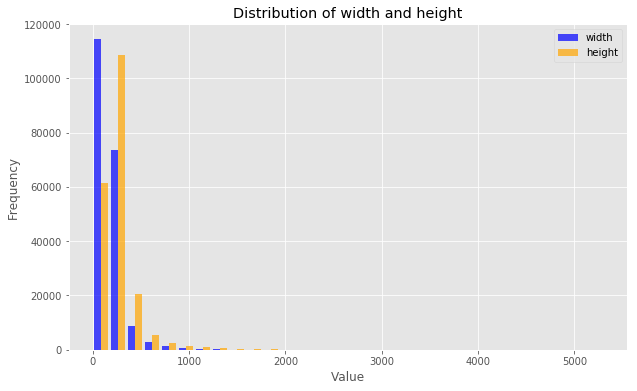

In [12]:
for i in range(0, len(bbox.columns), 2):
    graph(bbox.columns[i], bbox.columns[i+1], bbox)

In [13]:
bbox.describe()

,x_1,y_1,width,height
count,202599.000000,202599.000000,202599.000000,202599.000000
mean,156.764564,84.335505,194.754061,268.922329
std,164.518135,76.067284,141.770066,195.664936
min,1.000000,0.000000,0.000000,0.000000
25%,69.000000,44.000000,120.000000,166.000000
50%,110.000000,68.000000,164.000000,227.000000
75%,181.000000,98.000000,221.000000,306.000000
max,3840.000000,1858.000000,3827.000000,5299.000000


---
## Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth

In [14]:
landmarks = pd.read_csv(main_folder + 'list_landmarks_align_celeba.csv')
landmarks.set_index('image_id', inplace=True)
print(landmarks.shape)
landmarks.head()

(202599, 10)


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,69,109,106,113,77,142,73,152,108,154
000002.jpg,69,110,107,112,81,135,70,151,108,153
000003.jpg,76,112,104,106,108,128,74,156,98,158
000004.jpg,72,113,108,108,101,138,71,155,101,151
000005.jpg,66,114,112,112,86,119,71,147,104,150


In [15]:
landmarks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 10 columns):
lefteye_x       202599 non-null int64
lefteye_y       202599 non-null int64
righteye_x      202599 non-null int64
righteye_y      202599 non-null int64
nose_x          202599 non-null int64
nose_y          202599 non-null int64
leftmouth_x     202599 non-null int64
leftmouth_y     202599 non-null int64
rightmouth_x    202599 non-null int64
rightmouth_y    202599 non-null int64
dtypes: int64(10)
memory usage: 17.0+ MB


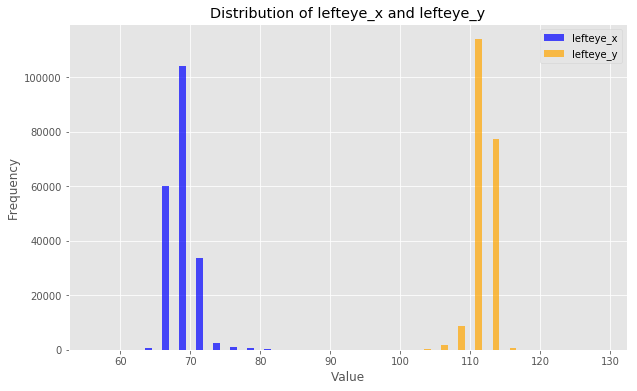

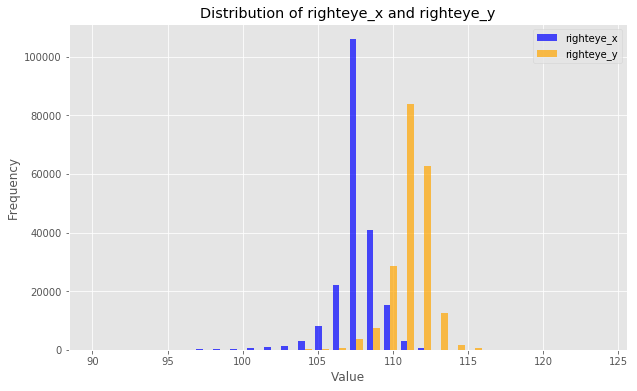

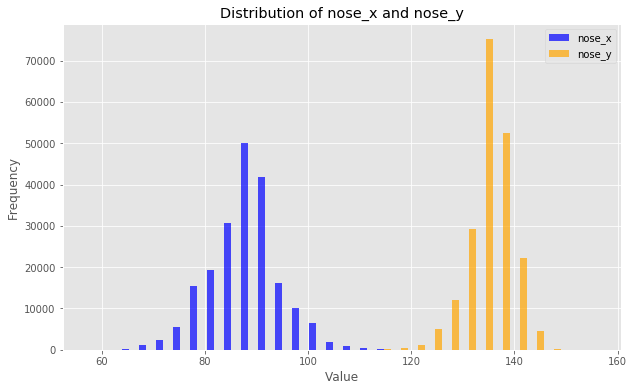

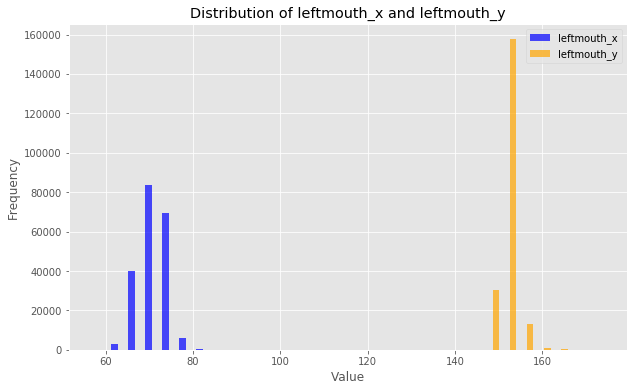

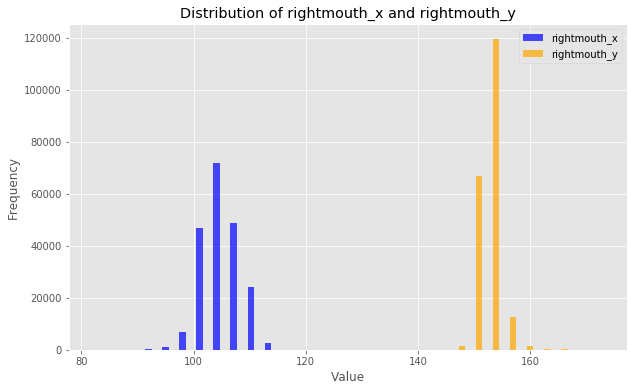

In [16]:
for i in range(0, len(landmarks.columns), 2):
    graph(landmarks.columns[i], landmarks.columns[i+1], landmarks)

---
## Split Dataset into Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is: 
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing

The partition is in file <b>list_eval_partition.csv</b>

Due time execution, by now we will be using a reduced number of images:

* Training 20000 images
* Validation 5000 images
* Test 5000 Images


In [17]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [18]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

#### Join the partition and the attributes in the same data frame

In [19]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Attractive'], how='inner')
df_par_attr.head()

,partition,Attractive
image_id,,
000001.jpg,0,1
000002.jpg,0,0
000003.jpg,0,0
000004.jpg,0,1
000005.jpg,0,1


### Generate Partitions (Train, Validation, Test)

In [20]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)
    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    df_ = df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_, df_par_attr[(df_par_attr['partition'] == partition) & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []
        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

## Pre-processing Images: Data Augmentation

### Let's start with an example: Data Augmentation

This is how an image will look like after data augmentation (based in the giving parameters below).

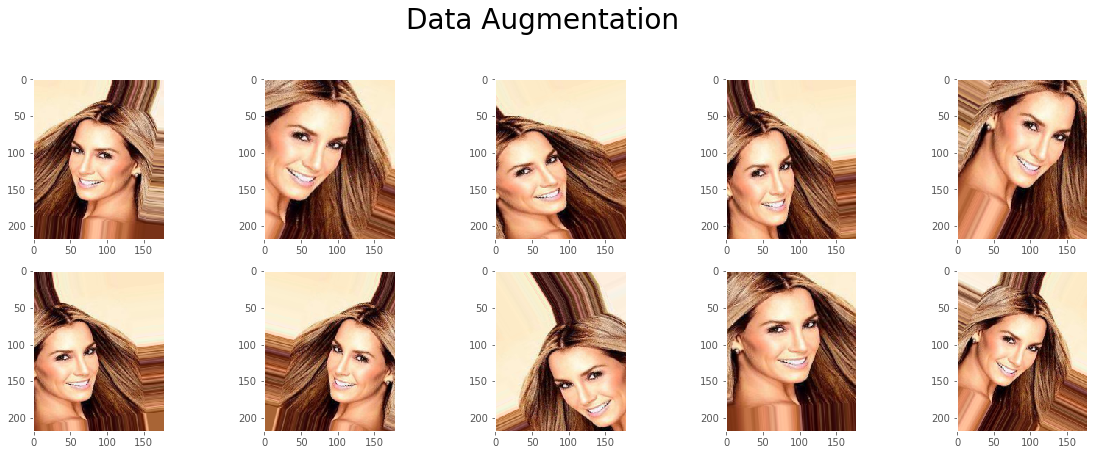

In [21]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1

plt.savefig('data_augmentation.png')
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.

### Build Data Generators

In [22]:
# Train data
x_train, y_train = generate_df(0, 'Attractive', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [23]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Attractive', VALIDATION_SAMPLES)

With the data generator created and data for validation, we are ready to start modeling.

## Build the Model - Attractiveness Recognition

### Set the Model

In [24]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
inc_model.summary()

number of layers: 311
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 108, 88, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 108, 88, 32)  96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 108, 88, 32)  0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [25]:
# Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [26]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [27]:
# https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.attractive.hdf5', verbose=1, save_best_only=True)

In [28]:
hist = model_.fit_generator(train_generator, 
                            validation_data = (x_valid, y_valid), 
                            steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE, 
                            epochs= NUM_EPOCHS, 
                            callbacks=[checkpointer], 
                            verbose=1
                           )

Epoch 1/20
313/312 [==============================] - 95s 303ms/step - loss: 0.6831 - acc: 0.5862 - val_loss: 0.6202 - val_acc: 0.6505

Epoch 00001: val_loss improved from inf to 0.62023, saving model to weights.best.inc.attractive.hdf5
Epoch 2/20
313/312 [==============================] - 82s 262ms/step - loss: 0.5919 - acc: 0.6899 - val_loss: 0.6087 - val_acc: 0.6890

Epoch 00002: val_loss improved from 0.62023 to 0.60870, saving model to weights.best.inc.attractive.hdf5
Epoch 3/20
313/312 [==============================] - 80s 255ms/step - loss: 0.5430 - acc: 0.7321 - val_loss: 0.6206 - val_acc: 0.7010

Epoch 00003: val_loss did not improve from 0.60870
Epoch 4/20
313/312 [==============================] - 80s 254ms/step - loss: 0.5174 - acc: 0.7487 - val_loss: 0.6290 - val_acc: 0.7065

Epoch 00004: val_loss did not improve from 0.60870
Epoch 5/20
313/312 [==============================] - 80s 256ms/step - loss: 0.4998 - acc: 0.7566 - val_loss: 0.6225 - val_acc: 0.7090

Epoch 00005:

#### The model after training got an accuracy over the validation data of 70.65%.

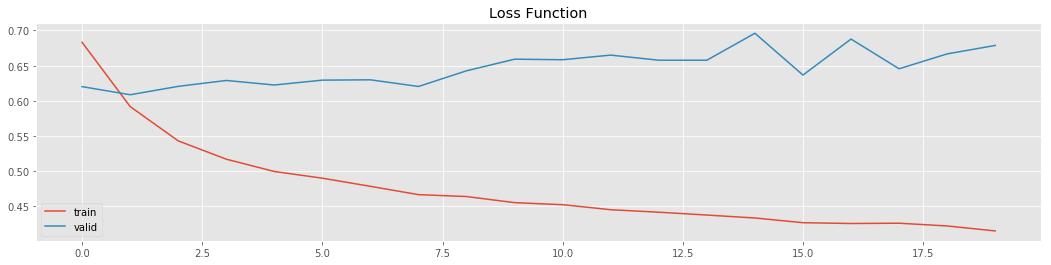

In [29]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.savefig('loss_function.png')
plt.show()

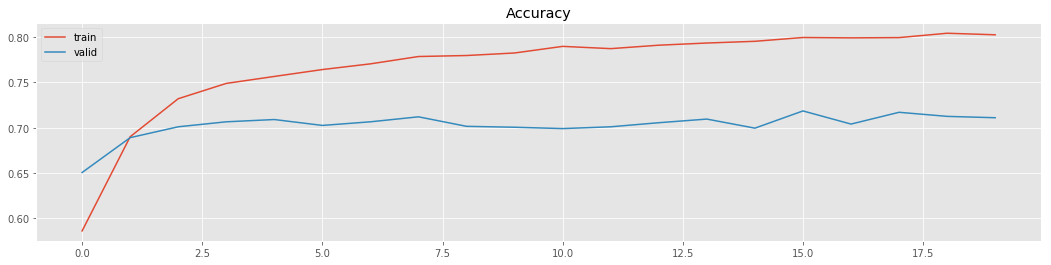

In [30]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.savefig('accuracy.png')
plt.show()

### Model Evaluation

In [31]:
#load the best model
model_.load_weights('weights.best.inc.attractive.hdf5')

In [32]:
# Test Data
x_test, y_test = generate_df(2, 'Attractive', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 69.5000%
f1_score: 0.7524350649350651


### Conclusion

The built model using transfer learning from the InceptionV3 and adding custom layers successfully recognize the gender giving certain picture with <b>69.5% of accuracy over the test data</b>.